При подготовке ноутбука использовались материалы:
1. [LDA topic modelling lenta Kaggle](https://www.kaggle.com/genyagree/lda-topic-modelling/notebook)
2. [LDA topic modelling visualization](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
3. [LDA topic modelling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

# Введение
**Latent Dirichlet Allocation** (LDA) - статистическая модель, позволяющая разделить набор текстов на $N$ подгрупп.

Каждый кластер характеризуется набором из $X$ ключевых слов. Эти ключевые слова ассоциируются с темой (topic). 

Каждый документ может быть представлен абором тем, каждая тема может быть представлена набором ключевых слов.

### Пример
У нас есть 3 документа:<br>
<br>
D1 = "Собаки любят играть"<br>
D2 = "Кошки любят молоко"<br>
D3 = "Кошки и собаки любят кушать и играть. Я люблю собак. Они милые"<br>

Topic Modelling может выдать следующую модель:<br>
<br>
D1 = 100% Topic1 + 0% Topic2<br>
D2 = 0% Topic1 + 100% Topic2<br>
D3 = 70% Topic1 + 30% Topic2<br>
<br>
Где каждая тема сформирована из слов (в порядке убывания значимости):<br>
<br>
Topic1 = 30% собака, 30% играть, 20% нравиться 10% милая 10% любить<br>
Topic2 = 50% кошка, 30% молоко, 20% нравиться<br>



# Зачем нужно LDA Topic Modeling

Общая задача тематического моделирования - обнаружение скрытой структуры в наборе текстовых данных. 
Для маленького количества текстов мы могли бы использовать просто tf-idf информацию, но для большого числа документов этого уже не достаточно

Практические применения:

1. [Суммаризация мнений](https://dl.acm.org/doi/10.1145/1076034.1076161)
Управляющим организациям, чьи решения влияют на большие группы людей может быть полезно суммаризовать информацию с выражением мнений из открытых источников (постов и комментариев в соцсетях)

2. [Bioinformatics](https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8)
Применение метода к "microarray datasets" - датасетам с последовательностями аминокилот или нуклеотидов - для выявления сткрытой структуры этих данных.

3. [Отслеживание трендов в тематиках корпусов текстов](https://timreview.ca/article/1170)
Анализ корпуса текстов - научных публикаций на определенную тему - позволяет отследить, как меняется взгляд на ту или иную научную проблему

4. [Рекомендательные системы](https://habr.com/ru/company/surfingbird/blog/150607/)
Если представить пользователя как набор описания продуктов, которые ему понравились, то можно находить тематики, интересующие пользователя и делать рекомендации в соответствии с ними.



   
# Немного теории
В latent diriclet allocaton (LDA) модели каждый документ в корпусе представляется в виде набора тем в соответствии с распределением Дирихле.

##  Постановка проблемы
- Коллекция документов $D$
- Каждый документ $d$ из коллекции представлен набором слов $W_{d} = (w_{1}, ..., w_{n_{d}})$ из словаря $W$, где $n_{d}$ - длина документа $d$
- Каждому документу соответствует набор тем
- Порядком слов в документе пренебрегают: каждый документ рассматривается как bag-of-words
- Каждая тема $t\in T$ (где $T$ - набор тем) описывается распределением Дирихле $p(w|t)$ на наборе слов $w\in W$, то есть тема представлена в виде вектора $\phi_{t} = (p(w|t):w \in W)$
- Каждый документ $d\in D$ описывается распределением Дирихле $p(t|d)$ на наборе тем $t\in T$. То есть документ описывается вектором $\theta_{d} = (p(t|d):t \in T)$
<br>

![](https://editor.analyticsvidhya.com/uploads/26864dtm.JPG)

Вероятность "возникновения" пары "документ-слово" можно записать следующим образом:

$$
p(w|d)=\sum\limits_{t\in T}p(w|t)p(t|d)
$$

![](https://miro.medium.com/max/780/1*QiTvyHNwvGI5UCqeKvhNsg.png)

## Решение
Построить модель тематического моделирования значит найти матрицы $\Phi = ||p(w|t)||$ и $\Theta = ||p(t|d)||$ на основе коллекции документов $D$.


Для нахождения решения нужно ршеить оптимизационную задачу - максимизировать следующую функцию (максимизируем likelihood наших данных с такими матрицами): 
$$
\sum\limits_{d\in D}\sum\limits_{w\in d}n_{dw}logp(w|d)\to\max\limits_{\Phi,\Theta},
$$
где $n_{dw}$ - частота слова $w$ в документе $d$.

In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
%matplotlib inline
import nltk
import pymorphy2
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Загрузка данных

In [2]:
DATA_DIR = "C:/DiskD/Computer_Science_Center/Machine learning/hw05"
DATA_FILE1 = "lenta-ru-news.csv"
DATA_FILE2 = ["pikabu_posts.csv", "pikabu_comments.csv"]

In [3]:
rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE1)).dropna()

<ipython-input-3-d6c4dfe9242c>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE1)).dropna()


In [4]:
rus_data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [5]:
rus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [6]:
rus_data['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

In [7]:
rus_data['topic'].value_counts(normalize=True)

Россия               0.217502
Мир                  0.191706
Экономика            0.107237
Спорт                0.081237
Культура             0.075114
Наука и техника      0.074561
Бывший СССР          0.072083
Интернет и СМИ       0.062332
Из жизни             0.038606
Дом                  0.030497
Силовые структуры    0.015748
Ценности             0.010638
Бизнес               0.010349
Путешествия          0.008938
69-я параллель       0.001779
Крым                 0.000935
Культпросвет         0.000477
Легпром              0.000160
Библиотека           0.000091
Оружие               0.000004
ЧМ-2014              0.000003
МедНовости           0.000001
Сочи                 0.000001
Name: topic, dtype: float64

## Чистка данных

In [8]:
# Удалим редко встречающиеся темы
def clean_data(df, cols, values):
    new = df
    for col in cols:
        new = new.query(f"{col} not in {values}").reset_index(drop=True)
    new = new.sample(10000, random_state = 42)
    data = new['text']
    return new, data

In [9]:
cols = ['topic']
values = ['Сочи', 'МедНовости', 'ЧМ-2014', 'Оружие', 'Библиотека', 'Легпром', 'Культпросвет', 'Крым', '69-я параллель']

In [10]:
rusdata_df, rusdata = clean_data(rus_data, cols, values)

In [11]:
rusdata

104902    В среду вечером глава ЦИК Украины Сергей Кивал...
91222     Теракты в Узбекистане 28 марта - 1 апреля пров...
677490    Европейская комиссия внесла спиннеры в список ...
90931     Коалиционные силы под руководством США начнут ...
47529     В пятницу на Иркутскую область обрушился мощны...
                                ...                        
678849    Госдума приняла в третьем чтении поправки в Жи...
641554    В Москве прошло официальное открытие флагманск...
469286    Турецкий пастух Мустафа Улькер, который 31 июл...
314699    В штате Джорджия бывший сотрудник компании, пр...
6610      С утра понедельника город Грозный снова открыт...
Name: text, Length: 10000, dtype: object

# Обработка данных

1. Удаление стоп-слов
2. Токенизация
2. Лемматизация
3. Построение словаря n-грамм
4. Tf-idf кодирование

 ## Удаление стоп-слов

1. Стоп-слова из библиотеки nltk
2. Дополнительный набор стоп-слов №1 ([github](https://github.com/stopwords-iso/stopwords-ru))
3. Дополнительный набор стоп-слов №2 ([github](https://github.com/Alir3z4/stop-words))

In [12]:
def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(DATA_DIR, "russian.txt"), 'rb') as f:
        stop_words_1 = f.read().decode("UTF-8").split("\n")
    with open(os.path.join(DATA_DIR, "stopwords-ru.txt"), 'rb') as f:
        stop_words_2 = f.read().decode("UTF-8").split("\n")
    return list(set(stopwordsrus+stop_words_1+stop_words_2))

In [13]:
stopwordsru = get_stop_words()

### Токенизация

In [14]:
# Все тексты - списки слов
def process(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha())

In [15]:
data = [process(t) for t in rusdata]

## Лемматизация

In [16]:
# Приведение слов к нормальной форме
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in text] for text in texts]

In [17]:
morph_data = lemmatizer(data)

In [18]:
def extract_lemma(texts):
    return [[word.normal_form for word in t] for t in texts]

In [19]:
# This is our lemmatized data ready to be used further:
data_norm = extract_lemma(morph_data)

In [21]:
def delete_stopwords(texts):
    return [[word for word in t if word not in stopwordsru] for t in texts]

In [22]:
# Удаление стоп-слов
my_data = delete_stopwords(data_norm)

# Визуализация

In [23]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

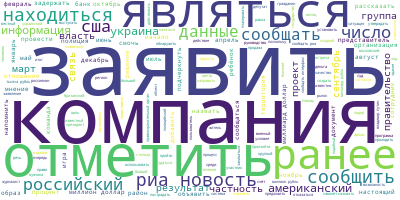

In [24]:
wordcloud_visualization(my_data)

## Построение n-грамм

*Смотри документацию [Phrases](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) и [Phraser](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.FrozenPhrases). Phraser ускоряет работу Phrases*

In [25]:
# Учет словосочетаний по 2-3 слова
bigram = gensim.models.Phrases(my_data, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[my_data], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [26]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(my_data)

In [27]:
print(data_words_trigrams[1])

['теракт', 'узбекистан', 'март', 'апрель', 'провести', 'экстремист', 'подпольный', 'организация', 'жамоат', 'сообщать', 'информационный_агентство', 'интерфакс', 'генпрокурор', 'республика', 'рашид', 'кадыров', 'заявить', 'брифинг', 'ташкент', 'апрель', 'результат', 'теракт', 'погибнуть', 'разный', 'данные', 'ранить', 'ход', 'проведение', 'спецоперация', 'непосредственно', 'взрыв', 'убить', 'террорист', 'предполагать', 'террорист', 'задержать', 'предъявить_обвинение', 'генпрокурор', 'арестовать', 'показание', 'обучение', 'боевой', 'подготовка', 'диверсионный', 'лагерь', 'проводиться', 'арабский', 'инструктор', 'готовить', 'боевик', 'генеральный_прокурор', 'следствие', 'установить', 'ташкент', 'ташкентский', 'бухарский', 'область', 'действовать', 'группа', 'жамоат', 'непосредственный', 'отношение', 'движение', 'генпрокурор', 'привлечение', 'член', 'организация', 'использоваться', 'религиозный', 'мотив', 'метод', 'психологический', 'воздействие', 'генпрокурор', 'пояснить', 'идеологический

## Создание словаря n-gram и BOW

*Смотри документацию [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary) и [doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).*

In [28]:
dictionary = corpora.Dictionary(data_words_trigrams) # каждому слову соответствует индекс

corpus = [dictionary.doc2bow(doc) for doc in data_words_trigrams] # документы в виде мешка слов
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


In [29]:
dictionary[8]

'достигнуть'

## Encoding Tf-Idf

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

[Статья с хорошим описанием](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)

$t$ — term (word)<br>
$d$ — document (set of words)<br>
$D$ - коллекция документов<br>
$N$ — размер коллекции документов $D$<br>


$$tf(t,d) = \frac{n_{td}}{n_{d}}$$
Частота встречаемости слова в документе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$df(t) = \sum_d{n_{td}}$$
Встречаемость слова в корпусе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$idf(t) = log(\frac{N}{df(t)+1})$$
Обратная встречаемость слова в корпусе.<br>
<br>

**$$tfidf(t,d) = tf(t,d)*idf(t)$$**

In [30]:
tfidf = gensim.models.TfidfModel(corpus=corpus, id2word=dictionary)

In [31]:
min_tfidf, max_tfidf = 1, 0
for doc in corpus:
    for word in tfidf.__getitem__(doc, eps=1e-12):
        if word[1] > max_tfidf:
            max_tfidf = word[1]
        if word[1] < min_tfidf:
            min_tfidf = word[1]
print(f'min_tfidf = {min_tfidf}, max_tfidf = {max_tfidf}')

min_tfidf = 0.0023421748343261935, max_tfidf = 1.0


array = [12, 761, 3293, 6978, 14422, 23535, 31654, 38261, 42454, 44525, 44201, 43571, 41925, 39496, 37010, 34276, 31377, 29045, 26095, 23979, 21746, 19496, 17685, 15828, 14016, 12655, 11070, 9790, 8642, 7714, 6831, 5985, 5329, 4850, 4312, 3925, 3358, 3193, 2988, 2704, 2498, 2217, 2131, 1886, 1750, 1721, 1631, 1471, 1393, 1355, 1208, 1197, 1125, 1022, 1008, 911, 828, 792, 794, 778, 718, 681, 689, 654, 586, 575, 508, 505, 486, 459, 427, 442, 374, 364, 342, 331, 330, 309, 261, 313, 273, 272, 277, 230, 249, 226, 218, 220, 207, 174, 168, 158, 173, 173, 169, 166, 150, 125, 128, 125, 140, 118, 102, 106, 110, 106, 85, 98, 91, 97, 83, 75, 83, 71, 87, 62, 75, 62, 59, 59, 49, 51, 58, 47, 54, 48, 50, 42, 47, 33, 40, 36, 45, 40, 30, 34, 34, 24, 25, 22, 11, 15, 16, 19, 19, 13, 25, 19, 13, 13, 11, 5, 8, 7, 11, 6, 6, 5, 4, 6, 1, 7, 6, 3, 3, 2, 2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 9]


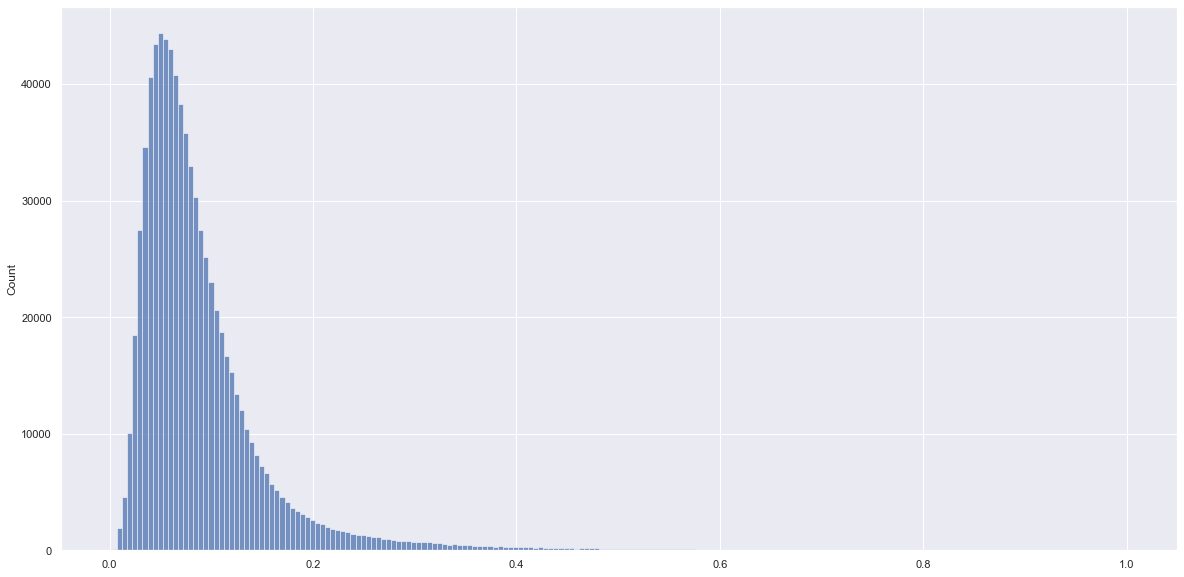

In [32]:
# шаг - 0.005, поэтому bins=200
import seaborn as sns
import math

bins = 200

array = [0] * bins
tfidfs = []
for doc in corpus:
    doc_tfidf = tfidf.__getitem__(doc, eps=1e-12)
    tfidfs.extend(list(map(lambda word: word[1], doc_tfidf)))
    for word in doc_tfidf:
        array[math.ceil(word[1] * bins) - 1] += 1

print(f'array = {array}')
sns.set(rc={"figure.figsize":(20, 10)})
sns_plot = sns.histplot(tfidfs, bins=bins)
fig = sns_plot.get_figure()

In [33]:
perc10 = np.percentile(tfidfs, q=10)
perc95 = np.percentile(tfidfs, q=95)
print(f'percentile10 = {perc10}, percentile95 = {perc95}')

percentile10 = 0.034662452171885176, percentile95 = 0.20985219470596342


In [34]:
filtered_corpus = []
for doc in corpus:
    doc_tfidf = tfidf.__getitem__(doc, eps=1e-12)
    list_with_None = list(map(lambda w_tfidf, w_doc: w_doc if w_tfidf[1] >= perc10 and w_tfidf[1] <= perc95 else None, doc_tfidf, doc))
    filtered_doc = list(filter(lambda x: x != None, list_with_None))
    filtered_corpus.append(filtered_doc)

# Построение модели LDA Topic Modelling

In [35]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=filtered_corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [36]:
lda_model_without_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [44]:
pprint(lda_model.show_topics(formatted=False))

[(41,
  [('volynpost', 1.578781e-05),
   ('раздутый', 1.578781e-05),
   ('войтович', 1.578781e-05),
   ('витер', 1.578781e-05),
   ('боруцкий', 1.578781e-05),
   ('башкаленко', 1.578781e-05),
   ('луцк', 1.578781e-05),
   ('шкиряк', 1.578781e-05),
   ('богомазов', 1.578781e-05),
   ('постелить', 1.578781e-05)]),
 (16,
  [('volynpost', 1.578781e-05),
   ('раздутый', 1.578781e-05),
   ('войтович', 1.578781e-05),
   ('витер', 1.578781e-05),
   ('боруцкий', 1.578781e-05),
   ('башкаленко', 1.578781e-05),
   ('луцк', 1.578781e-05),
   ('шкиряк', 1.578781e-05),
   ('богомазов', 1.578781e-05),
   ('постелить', 1.578781e-05)]),
 (0,
  [('volynpost', 1.578781e-05),
   ('раздутый', 1.578781e-05),
   ('войтович', 1.578781e-05),
   ('витер', 1.578781e-05),
   ('боруцкий', 1.578781e-05),
   ('башкаленко', 1.578781e-05),
   ('луцк', 1.578781e-05),
   ('шкиряк', 1.578781e-05),
   ('богомазов', 1.578781e-05),
   ('постелить', 1.578781e-05)]),
 (2,
  [('музыка', 0.078661494),
   ('австрия', 0.061170243

In [38]:
pprint(lda_model_without_tfidf.show_topics(formatted=False))

[(1,
  [('volynpost', 1.578781e-05),
   ('раздутый', 1.578781e-05),
   ('войтович', 1.578781e-05),
   ('витер', 1.578781e-05),
   ('боруцкий', 1.578781e-05),
   ('башкаленко', 1.578781e-05),
   ('луцк', 1.578781e-05),
   ('шкиряк', 1.578781e-05),
   ('богомазов', 1.578781e-05),
   ('постелить', 1.578781e-05)]),
 (54,
  [('volynpost', 1.578781e-05),
   ('раздутый', 1.578781e-05),
   ('войтович', 1.578781e-05),
   ('витер', 1.578781e-05),
   ('боруцкий', 1.578781e-05),
   ('башкаленко', 1.578781e-05),
   ('луцк', 1.578781e-05),
   ('шкиряк', 1.578781e-05),
   ('богомазов', 1.578781e-05),
   ('постелить', 1.578781e-05)]),
 (28,
  [('проезжать', 0.03797182),
   ('батарея', 0.028038625),
   ('индустриальный', 0.013289627),
   ('шкиряк', 1.4536523e-05),
   ('войтович', 1.4536523e-05),
   ('витер', 1.4536523e-05),
   ('боруцкий', 1.4536523e-05),
   ('башкаленко', 1.4536523e-05),
   ('луцк', 1.4536523e-05),
   ('volynpost', 1.4536523e-05)]),
 (61,
  [('курс', 0.2633629),
   ('генеральный_дирек

In [39]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=filtered_corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,78,67,0.2452,0.0764,"право, партия, напомнить, депутат, нарушение, ...","глава, республика, объявить, настоящий, руково...",В среду вечером глава ЦИК Украины Сергей Кивал...
1,77,63,0.2781,0.0584,"группа, ход, проверка, разный, проводиться, ед...","данные, обнаружить, управление, убийство, ране...",Теракты в Узбекистане 28 марта - 1 апреля пров...
2,13,18,0.2061,0.0779,"май, список, попасть, войти, поскольку, база, ...","доллар, европейский, европа, помочь, евро, вве...",Европейская комиссия внесла спиннеры в список ...
3,27,22,0.2394,0.1085,"заявление, участник, связь, подчеркнуть, моско...","заявить, бывший, территория, отношение, член, ...",Коалиционные силы под руководством США начнут ...
4,62,27,0.075,0.0742,"правительство, здание, гражданин, смочь, закон...","заявление, участник, связь, подчеркнуть, моско...",В пятницу на Иркутскую область обрушился мощны...
5,35,6,0.2018,0.1036,"продажа, версия, качество, известный, написать...","документ, издание, газета, отмечать, официальн...",Писатель Виктор Пелевин опубликует в июньском ...
6,4,33,0.1168,0.0864,"матч, счёт, местный, игра, победа, игрок, оста...","сша, переговоры, план, километр, подтвердить, ...","Новый очаг лесных пожаров возник во вторник, 2..."
7,49,67,0.1626,0.0994,"лидер, украина, встреча, украинский, президент...","глава, республика, объявить, настоящий, руково...",Президент России Владимир Путин заявил о намер...
8,27,14,0.1787,0.1095,"заявление, участник, связь, подчеркнуть, моско...","составить, рынок, составлять, уровень, цена, с...",Разработанный членами «Исламского государства»...
9,42,6,0.1892,0.0673,"отметить, ситуация, ведомство, развитие, следу...","документ, издание, газета, отмечать, официальн...",Министр обороны России Сергей Шойгу поручил вз...


In [40]:
df_dominant_topic.loc[2]["text"]

'Европейская комиссия внесла спиннеры в список опасных для здоровья непродовольственных товаров. Об этом сообщается в ежегодном отчете организации. Игрушка вошла в систему быстрого оповещения о продуктах, представляющих тот или иной риск. Этот порядок позволяет странам Евросоюза оперативно обмениваться сведениями о таких товарах и изымать их из продажи. Если в каком-то государстве вещь признали небезопасной, то информация об этом распространяется между всеми остальными. Спиннер попал в этот перечень из-за мелких деталей, которые может проглотить ребенок. В отчете поясняется, что это особенно касается моделей с электрической подсветкой — в них используются маленькие батарейки, они могут обжечь пищевод или кишечник, если попадут внутрь. В список также вошли некоторые популярные модели детских машинок и мотоциклов. В июне 2017 года сообщалось, что в США спиннеры со встроенной колонкой и аккумулятором самовоспламенились у некоторых владельцев. Спиннер — вращающаяся антистрессовая игрушка с

In [45]:
df_dominant_topic.loc[2]["Topic_Keywords1"]

'май, список, попасть, войти, поскольку, база, выступление, сведение, поступать, текст'

In [47]:
df_dominant_topic.to_csv('dominant_topic_tfidf_limit.csv', index= False)

In [48]:
df_topic_sents_keywords_without_tfidf = format_topics_sentences(ldamodel=lda_model_without_tfidf,
                                                                corpus=corpus, texts=rusdata.values)

df_dominant_topic_without_tfidf = df_topic_sents_keywords_without_tfidf.reset_index(drop = True)
df_dominant_topic_without_tfidf.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,78,6,0.5142,0.0761,"заявить, российский, представитель, сообщить, ...","сообщать, данные, являться, информация, сайт, ...",В среду вечером глава ЦИК Украины Сергей Кивал...
1,0,78,0.2875,0.1475,"теракт, проверка, следствие, движение, сведени...","заявить, российский, представитель, сообщить, ...",Теракты в Узбекистане 28 марта - 1 апреля пров...
2,78,13,0.1379,0.1107,"заявить, российский, представитель, сообщить, ...","представить, любой, устройство, модель, произв...",Европейская комиссия внесла спиннеры в список ...
3,22,78,0.1984,0.1805,"украина, территория, украинский, граница, сове...","заявить, российский, представитель, сообщить, ...",Коалиционные силы под руководством США начнут ...
4,78,6,0.1449,0.1154,"заявить, российский, представитель, сообщить, ...","сообщать, данные, являться, информация, сайт, ...",В пятницу на Иркутскую область обрушился мощны...
5,35,78,0.4465,0.1583,"журналист, известный, версия, написать, статья...","заявить, российский, представитель, сообщить, ...",Писатель Виктор Пелевин опубликует в июньском ...
6,52,6,0.282,0.2068,"километр, пожар, крым, научный, пожарный, чей,...","сообщать, данные, являться, информация, сайт, ...","Новый очаг лесных пожаров возник во вторник, 2..."
7,78,7,0.2016,0.1272,"заявить, российский, представитель, сообщить, ...","встреча, германия, путин, президент_владимир_п...",Президент России Владимир Путин заявил о намер...
8,45,14,0.138,0.1317,"требование, передача, связанный, частный, прис...","процент, рынок, составить, уровень, миллиард_д...",Разработанный членами «Исламского государства»...
9,78,42,0.198,0.136,"заявить, российский, представитель, сообщить, ...","объяснить, департамент, западный, задача, заве...",Министр обороны России Сергей Шойгу поручил вз...


In [49]:
df_dominant_topic_without_tfidf.loc[2]["text"]

'Европейская комиссия внесла спиннеры в список опасных для здоровья непродовольственных товаров. Об этом сообщается в ежегодном отчете организации. Игрушка вошла в систему быстрого оповещения о продуктах, представляющих тот или иной риск. Этот порядок позволяет странам Евросоюза оперативно обмениваться сведениями о таких товарах и изымать их из продажи. Если в каком-то государстве вещь признали небезопасной, то информация об этом распространяется между всеми остальными. Спиннер попал в этот перечень из-за мелких деталей, которые может проглотить ребенок. В отчете поясняется, что это особенно касается моделей с электрической подсветкой — в них используются маленькие батарейки, они могут обжечь пищевод или кишечник, если попадут внутрь. В список также вошли некоторые популярные модели детских машинок и мотоциклов. В июне 2017 года сообщалось, что в США спиннеры со встроенной колонкой и аккумулятором самовоспламенились у некоторых владельцев. Спиннер — вращающаяся антистрессовая игрушка с

In [50]:
df_dominant_topic_without_tfidf.loc[2]["Topic_Keywords1"]

'заявить, российский, представитель, сообщить, глава, ранее, отметить, власть, октябрь, май'

In [51]:
df_dominant_topic_without_tfidf.to_csv('dominant_topic_no_tfidf_limit.csv', index= False)

# Оценка качества

### Perplexity

[Подробное описание](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)


Оценка генеративной языковой модели.

Мы хотим, чтобы наша языковая модель приписывала высокие вероятности реальным предложениям и низкие - нереальным. Поэтому чем ниже PP, тем лучше.


$PP(W)$ - обратная вероятность тестового корпуса слов, нормированная на его размер

$$PP(W) = \frac1{P(w_1,...,w_N)^{\frac1N}}$$


In [52]:
# С tf-idf чуть лучше результат
print('\nPerplexity without tfidf: ', lda_model_without_tfidf.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.
print('\nPerplexity with tfidf: ', lda_model.log_perplexity(filtered_corpus))


Perplexity without tfidf:  -40.32557520337368

Perplexity with tfidf:  -40.61640188378936


## Визуализация

In [54]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_news_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(lda_model, filtered_corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_news_tfidf_limits' +'.html')
LDAvis_prepared

C:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27     0.210502  0.428227       1        1  6.103387
6      0.185554 -0.087962       2        1  4.408047
62     0.176363 -0.091827       3        1  3.911705
78     0.171004 -0.073423       4        1  3.665195
67     0.169840 -0.075588       5        1  3.635149
...         ...       ...     ...      ...       ...
64    -0.214838  0.006671      76        1  0.071919
2     -0.212680  0.006775      77        1  0.070405
0     -0.230544  0.005409      78        1  0.005339
16    -0.230544  0.005409      79        1  0.005335
41    -0.230544  0.005409      80        1  0.005293

[80 rows x 5 columns], topic_info=            Term         Freq        Total Category  logprob  loglift
630     компания  4576.000000  4576.000000  Default  30.0000  30.0000
1039     процент  3441.000000  3441.000000  Default  29.0000  29.0000
404   российский  3100.000000  3100.000000  Default  28.0000  28.0000
35     президент  2835.000000  2835.000000  Default  27.0000  27.0000
258          сша  3032.000000  3032.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
25    отвергнуть     0.000667    60.140541  Topic80 -11.0563  -1.5630
26      открытый     0.000667   200.159383  Topic80 -11.0563  -2.7654
27      отложить     0.000667   161.656657  Topic80 -11.0563  -2.5518
28      отметить     0.000667  1106.329512  Topic80 -11.0563  -4.4751
29      передать     0.000667   543.776064  Topic80 -11.0563  -3.7649

[2878 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1112     30  0.995654          afp
2476     20  0.993781       agence
1343     60  0.946632          all
1646     58  0.995203           ap
3098     30  0.976118          bbc
...     ...       ...          ...
1520     73  0.994506      ядерный
1270     63  0.997722        якобы
610      34  0.999110       январь
2144     21  0.994231       япония
3172     35  0.890091  ярославский

[1928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 7, 63, 79, 68, 53, 72, 64, 14, 57, 15, 23, 67, 29, 62, 43, 74, 24, 13, 48, 19, 5, 78, 80, 34, 56, 2, 10, 70, 31, 25, 40, 12, 54, 49, 16, 50, 33, 8, 6, 27, 69, 36, 39, 66, 76, 71, 30, 75, 9, 52, 38, 21, 45, 37, 73, 58, 35, 60, 22, 77, 18, 41, 4, 47, 32, 61, 11, 26, 59, 20, 46, 44, 51, 55, 65, 3, 1, 17, 42])

Общие выводы:

Большинство тем связаны с политикой, что неудивительно, учитывая состав 'topics' в исходных данных.

Редко встречаются n-граммы, при этом периодически в ключевых словах попадаются отдельные имена, их лучше связывать принудительно в ФИО и, скажем, должность, сами имена не несут информации.

Встречаются n-граммы, состоящие из слов разных языков - надо либо переводить, либо избавляться от иностранных слов.

У первой темы важность ключевых слов распределяется равномерней всего, дальше равномерность уходит. Равномерность и характеризует то, насколько сильно тема выделяется в тексте. Чем больше важных ключевых слов, тем лучше выделение темы.

# Задание

## Использование корпуса c TF-IDF фильтрацией (10 баллов)

TFIDF коэффициенты выделяют слова, которые являются часто употребимыми (не несут информации о конкретном документе) или те, которые встречаются только в одном документе и не могут показать скрытую связь между документами. 

В этом задании нужно
1. Найти максимальное и минимальное значение tfidf скора

*Подсказка*: нужно проитерироваться по всему корпусу слов, посчитать tfidf скор и найти пороговые значения

2. Построить дискретный массив tfidf скоров с шагом 0.005 и найти перцентили 10 и 95

3. Отфильтровать corpus в filtered_corpus, оставив только слова со скорами, попадающими в диапазон от 10 до 95 перцентилей.
4. Построить подель LDA на отфильтрованном корпусе
5. Посчитать метрики качества
5. Сделать визуализацию тематик
6. Посмотреть на темы с наибольшими коэффициентами в датафрейме
7. Напишите, какой вывод можно сделать

**Комментарий** - можно уменьшать количество  $n_topics$, если вашему компьютеру не хватает вычислительных мощностей.

**Комментарий** - если при визуализации вы получили ошибку `TypeError: Object of type complex is not JSON serializable`, добавьте в метод `prepare` аргумент `mds='mmds'`

## Дополнительное задание (2 балла)

Постройте LDA Topic modelling модель для [датасета постов о политике с Пикабу](https://www.kaggle.com/atomin/pikabu-politic-posts). 

При построении можете поизменять параметры `alpha` и `beta` для получения более качественной модели.

Какие выводы можно сделать на основе полученной модели?

In [65]:
posts_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE2[0])).dropna()

In [67]:
posts_data.head()

,url,author,content,date_published,comments_count,views,saves,shares,likes,dislikes,tag
0,https://pikabu.ru/story/ya_za_lukashenko_golos...,evgeny8ch,"Не помогло, всё равно задержали\nПикабу●0:18\n...",2020-08-13 17:57:24,173,70281,48,1,1092,115,Политика
1,https://pikabu.ru/story/initsiativa_za_zapret_...,iLeech,Вышеупомянутая инициатива была опубликована на...,2020-09-01 09:32:28,51,53158,46,0,847,33,Политика
2,https://pikabu.ru/story/offshornomonopolnaya_k...,dlyasvadb,Мост через реку Пур с госучастием строят по сф...,2020-08-19 20:33:28,38,48007,25,0,846,25,Политика
3,https://pikabu.ru/story/rabotniki_grodnoazot_o...,Wunderwaffen,"Работники ""ГродноАзот"" обьявили забастовку в с...",2020-08-13 17:00:24,194,58260,18,1,1096,92,Политика
6,https://pikabu.ru/story/situatsiya_v_belarusi_...,Telemaks,С 2003 года я не смотрел и не слушал выступлен...,2020-08-19 08:09:22,2218,117633,262,6,3758,362,Политика


In [68]:
posts_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 0 to 711
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             622 non-null    object
 1   author          622 non-null    object
 2   content         622 non-null    object
 3   date_published  622 non-null    object
 4   comments_count  622 non-null    int64 
 5   views           622 non-null    int64 
 6   saves           622 non-null    int64 
 7   shares          622 non-null    int64 
 8   likes           622 non-null    int64 
 9   dislikes        622 non-null    int64 
 10  tag             622 non-null    object
dtypes: int64(6), object(5)
memory usage: 58.3+ KB


In [69]:
postsdata = posts_data['content']

In [70]:
postsdata

0      Не помогло, всё равно задержали\nПикабу●0:18\n...
1      Вышеупомянутая инициатива была опубликована на...
2      Мост через реку Пур с госучастием строят по сф...
3      Работники "ГродноАзот" обьявили забастовку в с...
6      С 2003 года я не смотрел и не слушал выступлен...
                             ...                        
707        http://www.dni.ru/polit/2016/7/20/342823.html
708                                               ссылка
709    Недавно суд Чеченской республики списал жителя...
710                                            via\nпруф
711    Депутаты предложили разрешить отвязывать полис...
Name: content, Length: 622, dtype: object

In [71]:
postdata = [process(t) for t in postsdata]

In [72]:
morph_postdata = lemmatizer(postdata)

In [73]:
postdata_norm = extract_lemma(morph_postdata)

In [74]:
my_postdata = delete_stopwords(postdata_norm)

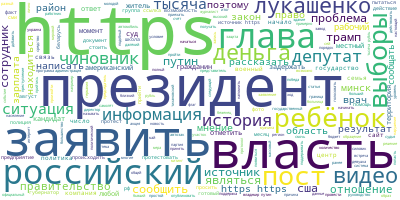

In [75]:
wordcloud_visualization(my_postdata)

In [78]:
# Удалим везде 'http'
my_postdata = [[word for word in t if word.find("http") == -1] for t in my_postdata]

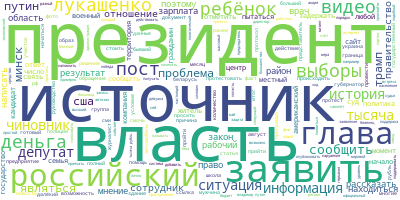

In [79]:
wordcloud_visualization(my_postdata)

In [80]:
# Учет словосочетаний по 2-3 слова
bigram = gensim.models.Phrases(my_postdata, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[my_postdata], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [81]:
postdata_words_trigrams = make_trigrams(my_postdata)

In [82]:
print(postdata_words_trigrams[1])

['вышеупомянутый', 'инициатива', 'опубликовать', 'рой', 'российский', 'общественный', 'инициатива', 'август', 'момент', 'публикация', 'набрать', 'ровно', 'радовать', 'поскольку', 'инициатива', 'проблема', 'сфера', 'договор', 'касаться', 'современный', 'услуга', 'вроде', 'сервис', 'каршеринг', 'договор', 'обработка', 'персональный', 'данные', 'договор', 'цифровой', 'услуга', 'разный', 'род', 'ключевой', 'проблема', 'мнение', 'автор', 'инициатива', 'являться', 'возможность', 'договор', 'изменить', 'исполнитель', 'услуга', 'односторонний', 'порядок', 'многий', 'договор', 'пункт', 'прописать', 'прямой', 'текст', 'сервис', 'предоставлять', 'иной', 'услуга', 'изменить', 'ответственность', 'явный', 'перевес', 'преференция', 'увеличить', 'штрафной', 'санкция', 'нарушение', 'правило', 'сервис', 'дополнительный', 'уведомление', 'пользователь', 'ситуация', 'заключить', 'договор', 'каршеринговый', 'компания', 'принять', 'ответственность', 'рамка', 'цифра', 'скажем', 'рубль', 'утром', 'воспользоват

In [83]:
post_dictionary = corpora.Dictionary(postdata_words_trigrams) # каждому слову соответствует индекс

post_corpus = [post_dictionary.doc2bow(doc) for doc in postdata_words_trigrams] # документы в виде мешка слов
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


In [85]:
post_dictionary[6]

'трансляция'

In [86]:
post_tfidf = gensim.models.TfidfModel(corpus=post_corpus, id2word=post_dictionary)

In [87]:
min_tfidf, max_tfidf = 1, 0
for doc in post_corpus:
    for word in post_tfidf.__getitem__(doc, eps=1e-12):
        if word[1] > max_tfidf:
            max_tfidf = word[1]
        if word[1] < min_tfidf:
            min_tfidf = word[1]
tf_max = max_tfidf
tf_min = min_tfidf
print(tf_max, tf_min)

1.0 0.005699415238352561


array = [0, 109, 1022, 2383, 2933, 3203, 3549, 3024, 2738, 2342, 2325, 1955, 1741, 1459, 1536, 1142, 980, 1013, 788, 672, 703, 530, 540, 524, 418, 391, 380, 323, 321, 269, 268, 286, 209, 199, 221, 195, 178, 156, 111, 192, 124, 113, 99, 103, 123, 64, 103, 74, 96, 87, 62, 56, 88, 44, 52, 47, 44, 40, 58, 46, 51, 33, 46, 41, 27, 33, 35, 23, 24, 27, 33, 27, 32, 15, 33, 19, 18, 24, 18, 13, 19, 10, 10, 10, 17, 14, 15, 12, 9, 16, 9, 17, 10, 15, 7, 17, 5, 5, 9, 4, 6, 4, 11, 5, 4, 6, 3, 5, 2, 8, 8, 6, 5, 3, 2, 5, 2, 8, 5, 5, 4, 1, 4, 3, 3, 2, 4, 1, 5, 1, 3, 2, 1, 0, 2, 0, 3, 2, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39]


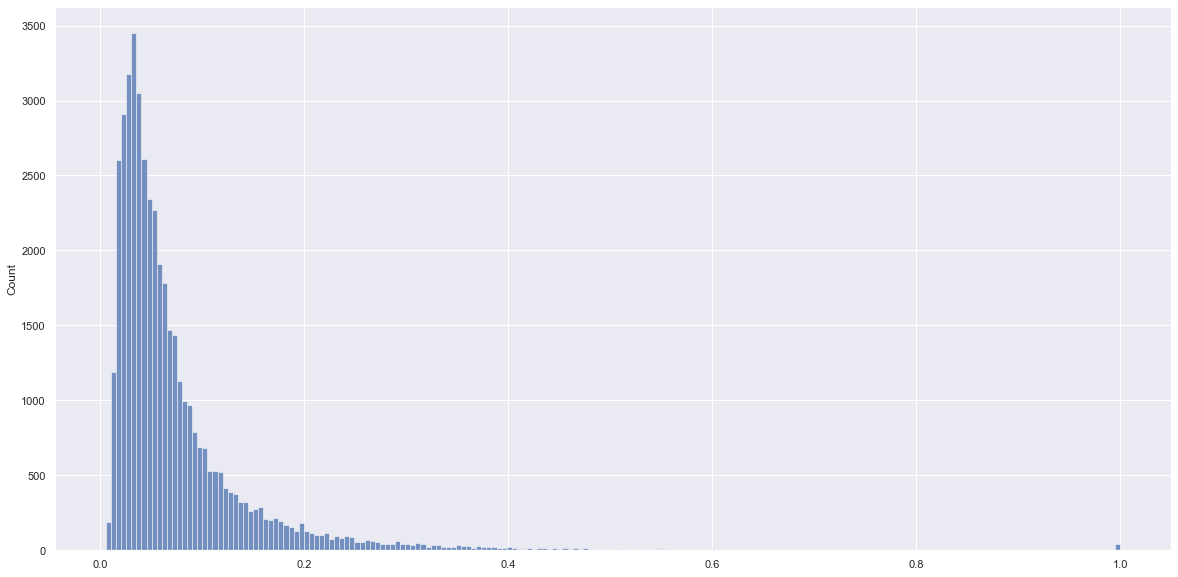

In [88]:
# шаг - 0.005, поэтому bins=200
bins = 200

array = [0] * bins
tfidf_range = []
for doc in post_corpus:
    doc_tfidf = post_tfidf.__getitem__(doc, eps=1e-12)
    tfidf_range.extend(list(map(lambda word: word[1], doc_tfidf)))
    for word in doc_tfidf:
        array[math.ceil(word[1] * bins) - 1] += 1

print(f'array = {array}')
sns.set(rc={"figure.figsize":(20, 10)})
sns_plot = sns.histplot(tfidf_range, bins=bins)
fig = sns_plot.get_figure()

In [89]:
print(np.percentile(tfidf_range, 95), np.percentile(tfidf_range, 10))

0.2152180550713626 0.021505010234971162


In [91]:
low_value = np.percentile(tfidf_range, 10) 
high_value = np.percentile(tfidf_range, 95) 

filtered_post_corpus = []
for doc in post_corpus:
    doc_tfidf = post_tfidf.__getitem__(doc, eps=1e-12)
    list_with_None = list(map(lambda w_tfidf, w_doc: w_doc if w_tfidf[1] >= low_value and w_tfidf[1] <= high_value else None,
                              doc_tfidf, doc))
    filtered_doc = list(filter(lambda x: x != None, list_with_None))
    filtered_post_corpus.append(filtered_doc)

In [99]:
corpuses = [post_corpus, filtered_post_corpus]
alpha = ['auto', 'symmetric', 'asymmetric', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
eta = ['auto', 'symmetric', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = {'corpus': [], 'alpha': [], 'eta': [], 'perplexity': []}
best_perplexity = 1000
best_lda_model_tfidf = 0
j = 0
for i, corp in enumerate(corpuses):
    for al in alpha:
        for et in eta:
            j += 1
            lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corp,
                                           id2word=post_dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=al,
                                           eta=et,
                                           per_word_topics=True)
            perplexity = lda_model_tfidf.log_perplexity(corp)
            if best_perplexity > perplexity:
                best_perplexity = perplexity
                best_lda_model_tfidf = lda_model_tfidf
            results['corpus'].append(i)
            results['alpha'].append(al)
            results['eta'].append(et)
            results['perplexity'].append(perplexity)
            print(f'Выполнено: {j * 100 / (len(corpuses) * len(alpha) * len(eta))}%')

Выполнено: 0.3787878787878788%
Выполнено: 0.7575757575757576%
Выполнено: 1.1363636363636365%
Выполнено: 1.5151515151515151%
Выполнено: 1.893939393939394%
Выполнено: 2.272727272727273%
Выполнено: 2.6515151515151514%
Выполнено: 3.0303030303030303%
Выполнено: 3.409090909090909%
Выполнено: 3.787878787878788%
Выполнено: 4.166666666666667%
Выполнено: 4.545454545454546%
Выполнено: 4.924242424242424%
Выполнено: 5.303030303030303%
Выполнено: 5.681818181818182%
Выполнено: 6.0606060606060606%
Выполнено: 6.4393939393939394%
Выполнено: 6.818181818181818%
Выполнено: 7.196969696969697%
Выполнено: 7.575757575757576%
Выполнено: 7.954545454545454%
Выполнено: 8.333333333333334%
Выполнено: 8.712121212121213%
Выполнено: 9.090909090909092%
Выполнено: 9.469696969696969%
Выполнено: 9.848484848484848%
Выполнено: 10.227272727272727%
Выполнено: 10.606060606060606%
Выполнено: 10.984848484848484%
Выполнено: 11.363636363636363%
Выполнено: 11.742424242424242%
Выполнено: 12.121212121212121%
Выполнено: 12.5%
Выполнено

In [100]:
print('\nBest perplexity: ', best_perplexity)


Best perplexity:  -50.31550699725606


In [105]:
print('corpus, alpha, eta, perplexity:\n')
best_perplexity = 1000
best_results = {'corpus': 0, 'alpha': 0, 'eta': 0}
for i in range(len(corpuses) * len(alpha) * len(eta)):
    print(f"{results['corpus'][i]}, {results['alpha'][i]}, {results['eta'][i]}, {results['perplexity'][i]}\n")
    if best_perplexity > results['perplexity'][i]:
        best_perplexity = results['perplexity'][i]
        best_results['corpus'] = results['corpus'][i]
        best_results['alpha'] = results['alpha'][i]
        best_results['eta'] = results['eta'][i]

corpus, alpha, eta, perplexity:

0, auto, auto, -39.45187141908392

0, auto, symmetric, -39.4527537881122

0, auto, 0.1, -10.045002449958533

0, auto, 0.2, -9.257605413609665

0, auto, 0.3, -9.108107956948011

0, auto, 0.4, -9.09974064498438

0, auto, 0.5, -9.09671621989675

0, auto, 0.6, -9.095022144516786

0, auto, 0.7, -9.092493598731073

0, auto, 0.8, -9.089444609187563

0, auto, 0.9, -9.087989039059408

0, symmetric, auto, -39.608149750306346

0, symmetric, symmetric, -39.60909206277133

0, symmetric, 0.1, -10.158525541088505

0, symmetric, 0.2, -9.333765297971599

0, symmetric, 0.3, -9.159442167499746

0, symmetric, 0.4, -9.162562722790868

0, symmetric, 0.5, -9.169362823088212

0, symmetric, 0.6, -9.16577207244588

0, symmetric, 0.7, -9.165263393007782

0, symmetric, 0.8, -9.176328805094974

0, symmetric, 0.9, -9.18461384456333

0, asymmetric, auto, -39.63090346415163

0, asymmetric, symmetric, -39.63186342973264

0, asymmetric, 0.1, -10.182203745130673

0, asymmetric, 0.2, -9.2

In [106]:
print(f"best results: {best_results}")

best results: {'corpus': 1, 'alpha': 0.9, 'eta': 'symmetric'}


In [107]:
# Show Topics
pprint(best_lda_model_tfidf.show_topics(formatted=False))

[(33,
  [('политик', 0.06958918),
   ('наверное', 0.05565043),
   ('остаток', 0.049241077),
   ('ядерный', 0.023858223),
   ('реформа', 0.02084887),
   ('следовать', 5.6944747e-05),
   ('обеспечение', 5.6922978e-05),
   ('президент', 5.692297e-05),
   ('источник', 5.6922956e-05),
   ('заявить', 5.6922956e-05)]),
 (16,
  [('лидер', 0.13000776),
   ('уверенный', 0.066673085),
   ('намеренный', 0.019095106),
   ('президент', 5.731779e-05),
   ('источник', 5.7176243e-05),
   ('сторонник', 5.7163415e-05),
   ('сша', 5.716339e-05),
   ('партия', 5.7163375e-05),
   ('украина', 5.7163365e-05),
   ('мужчина', 5.716335e-05)]),
 (26,
  [('глава', 0.2053689),
   ('бюджет', 0.1661924),
   ('доход', 0.048417583),
   ('оказывать', 0.030049924),
   ('обязанность', 0.029777925),
   ('ясно', 0.0280027),
   ('россиянин', 0.018401014),
   ('заработок', 0.012591602),
   ('принять', 3.362979e-05),
   ('рубль', 3.3629727e-05)]),
 (36,
  [('поскольку', 7.2875766e-05),
   ('заявить', 7.287567e-05),
   ('путин'

In [108]:
df_posts_topic_sents_keywords = format_topics_sentences(ldamodel=best_lda_model_tfidf,
                                                        corpus=filtered_post_corpus, texts=postsdata.values)


df_dominant_topic = df_posts_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,0,1,0.0125,0.0125,"государство, население, мера, ссылка, введение...","соцсеть, неизвестный, ранее, соответствие, тир...","Не помогло, всё равно задержали\nПикабу●0:18\n..."
1,6,71,0.1245,0.0896,"администрация, деньга, чиновник, политический,...","житель, написать, представитель, млн, пытаться...",Вышеупомянутая инициатива была опубликована на...
2,24,71,0.2649,0.1256,"область, просить, месяц, гражданин, сотрудник,...","житель, написать, представитель, млн, пытаться...",Мост через реку Пур с госучастием строят по сф...
3,17,24,0.0272,0.0241,"центр, правило, вести, проведение, лукашенко, ...","область, просить, месяц, гражданин, сотрудник,...","Работники ""ГродноАзот"" обьявили забастовку в с..."
4,6,17,0.1537,0.1234,"администрация, деньга, чиновник, политический,...","центр, правило, вести, проведение, лукашенко, ...",С 2003 года я не смотрел и не слушал выступлен...
5,24,17,0.0591,0.0496,"область, просить, месяц, гражданин, сотрудник,...","центр, правило, вести, проведение, лукашенко, ...","Работник ""Гродножилстрой"" на встрече с директо..."
6,9,73,0.1417,0.0946,"президент, российский, сша, сообщить, правител...","смочь, миллион, семья, полный, многие, врач, д...",На волнах Орды рубрика «Среди твоих детей мало...
7,73,71,0.1805,0.1274,"смочь, миллион, семья, полный, многие, врач, д...","житель, написать, представитель, млн, пытаться...",В больницу из Партизанского РУВД Минска привез...
8,0,1,0.0125,0.0125,"государство, население, мера, ссылка, введение...","соцсеть, неизвестный, ранее, соответствие, тир...",https://twitter.com/GolosAmeriki/status/129578...
9,0,1,0.0125,0.0125,"государство, население, мера, ссылка, введение...","соцсеть, неизвестный, ранее, соответствие, тир...",Наверное дедушка злостный террорист. Почему та...


In [109]:
df_dominant_topic.loc[2]["text"]

'Мост через реку Пур с госучастием строят по сфабрикованным документам - это всплыло лишь после снятия Александра Герасименко с поста прокурора Ямала.\n\nОчередной коррупционный скандал на Ямале – оказалось, что мост через реку Пур с госучастием строят по сфабрикованным документам. На нем отмываются миллиарды бюджетных средств, уверены опрошенные нами специалисты, причем все это покрывают силовики, коррумпированные чиновники администрации ЯНАО и менеджеры Газпрома. Данная информация нуждается в тщательном расследовании федеральных правоохранительных органов. Строительство моста ведет «Мостострой-11», который прославился на всю страну после строительства ряда олимпийских объектов (кстати, по некоторым оценкам, на сочинских стройках «распилили» до 30 млрд долларов). А собственник тюменской компании – близкий товарищ прокурора Герасименко, сообщают наши источники. Не потому ли сфабрикованные документы по мосту всплыли только после того, как «крышу» поперли с должности? Сейчас жители трех 

In [110]:
# Видно, что кое-какой смысл улавливается, хотя главные ключевые слова найдены не до конца
df_dominant_topic.loc[2]["Topic_Keywords1"]

'область, просить, месяц, гражданин, сотрудник, интерес, информация, помогать, право, компания'

In [111]:
df_dominant_topic.to_csv('posts_dominant_topic_tfidf_limit.csv', index= False)

In [113]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_posts_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(best_lda_model_tfidf, filtered_post_corpus, post_dictionary, mds='mmds')
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_posts_tfidf_limits' +'.html')
LDAvis_prepared

C:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.532694  0.049623       1        1  9.990193
24     0.236252  0.469044       2        1  8.223463
73     0.356341  0.283918       3        1  4.578505
9     -0.487081 -0.106643       4        1  4.504223
19     0.292903 -0.369850       5        1  4.341325
...         ...       ...     ...      ...       ...
7     -0.012247  0.006892      76        1  0.547920
52    -0.012318  0.006908      77        1  0.547920
68    -0.012263  0.006904      78        1  0.547920
67    -0.012287  0.006923      79        1  0.547920
59    -0.012249  0.006927      80        1  0.547920

[80 rows x 5 columns], topic_info=                 Term        Freq       Total Category  logprob  loglift
2184          депутат  129.000000  129.000000  Default  30.0000  30.0000
804           ребёнок  193.000000  193.000000  Default  29.0000  29.0000
257           местный  121.000000  121.000000  Default  28.0000  28.0000
213            житель  161.000000  161.000000  Default  27.0000  27.0000
230          источник  103.000000  103.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
19              вроде    0.019459   23.405413  Topic80  -9.5268  -1.8856
20            вызвать    0.019459   27.678371  Topic80  -9.5268  -2.0533
23        голосование    0.019459   15.734313  Topic80  -9.5268  -1.4885
24    государственный    0.019459   77.396527  Topic80  -9.5268  -3.0816
25             данные    0.019459   56.162396  Topic80  -9.5268  -2.7609

[3669 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
994      12  0.916388         upd
9         3  0.414862      август
9         4  0.092192      август
9         6  0.484005      август
142       1  0.084833  автомобиль
...     ...       ...         ...
452      39  0.928412       юрист
140      14  0.987555    являться
1582     43  0.854127     ядерный
456      10  0.953123       якобы
653      20  0.933181        ясно

[902 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 25, 74, 10, 20, 18, 59, 72, 80, 64, 35, 41, 14, 70, 15, 79, 1, 6, 71, 27, 12, 26, 77, 33, 67, 28, 65, 50, 40, 19, 76, 73, 57, 62, 52, 39, 22, 44, 13, 17, 66, 63, 34, 45, 75, 51, 49, 38, 32, 16, 3, 46, 29, 48, 30, 42, 5, 24, 56, 43, 47, 4, 2, 36, 21, 9, 54, 61, 78, 58, 55, 31, 11, 37, 23, 8, 53, 69, 68, 60])

Замечания здесь примерно те же, что и с новостями. 

Сразу можно увидеть разницу постов и новостей в том, что новостей по темам больше, поэтому в новостях только последние 3 темы имеют ключевые слова одинаково значимые для всех тем. В постах уже после 40-ой темы выделяется не более 5-ти ключевых слов, поэтому для постов надо выбирать меньше тем.